In [272]:
import os
import cv2
import shutil
import rasterio
import numpy as np 
import pandas as pd 
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split



for dirname, _, filenames in os.walk('/kaggle/input'):
    
    print(os.path.join(dirname))


/kaggle/input
/kaggle/input/water-segmentation-multispectral-and-optical-data
/kaggle/input/water-segmentation-multispectral-and-optical-data/data
/kaggle/input/water-segmentation-multispectral-and-optical-data/data/labels
/kaggle/input/water-segmentation-multispectral-and-optical-data/data/images


In [273]:
# mode 
mode = 0o666
   
# Path 
path1 = "/kaggle/working/water-segmentation-multispectral-and-optical-data"
path2 = "/kaggle/working/water-segmentation-multispectral-and-optical-data/data"
if not Path(path1).exists():
    os.mkdir(path1, mode) 
    
    
if not Path(path2).exists():
    os.mkdir(path2, mode)  

In [274]:
DATA_PATH = "/kaggle/input/water-segmentation-multispectral-and-optical-data/data"
IMAGES= "images"
LABEL= "labels"
LabelAfterEdit="labelsAfterEdit"
LABELS_PATH = "/kaggle/working/water-segmentation-multispectral-and-optical-data/data/labels"
IMG_PATH ="/kaggle/input/water-segmentation-multispectral-and-optical-data/data/images/94.tif"
IMG_LABEL= "/kaggle/input/water-segmentation-multispectral-and-optical-data/data/labels/0.png"


In [275]:
data = {}
data[IMAGES] = []
data[LABEL] = []
data[LabelAfterEdit] = []
for dirname in os.listdir(DATA_PATH):
    print()
    for file in os.listdir(os.path.join(f'{DATA_PATH}/{dirname}')):
        data[dirname].append(os.path.join(f'{DATA_PATH}/{dirname}/{file}'))
        
        
print(f"the len of images : {len(data[IMAGES])}")
print(f"the len of Labels : {len(data[LABEL])}")



the len of images : 306
the len of Labels : 456


In [276]:
 for file in os.listdir(os.path.join(f'{DATA_PATH}/{LABEL}')):
    if len( file.split("_")) == 1:
        if not Path(f"/kaggle/working/water-segmentation-multispectral-and-optical-data/data/{LABEL}").exists():
            os.mkdir(f"/kaggle/working/water-segmentation-multispectral-and-optical-data/data/{LABEL}", mode) 
        shutil.copy(os.path.join(f'{DATA_PATH}/{LABEL}/{file}'), f"/kaggle/working/water-segmentation-multispectral-and-optical-data/data/{LABEL}")


In [277]:
    for file in os.listdir(os.path.join(f'{LABELS_PATH}')):
        data[LabelAfterEdit].append(os.path.join(f'{LABELS_PATH}/{file}'))
        
        
print(f"the len of images : {len(data[IMAGES])}")
print(f"the len of Labels : {len(data[LabelAfterEdit])}")

the len of images : 306
the len of Labels : 306


In [278]:
data[IMAGES] = sorted(data[IMAGES])
data[LabelAfterEdit] = sorted(data[LabelAfterEdit])

In [279]:
for i in range(10):
    print(f"image : ..{data[IMAGES][i][-20:]} = Label: ..{data[LabelAfterEdit][i][-20:]}'")

image : ..ta/data/images/0.tif = Label: ..ta/data/labels/0.png'
image : ..ta/data/images/1.tif = Label: ..ta/data/labels/1.png'
image : ..a/data/images/10.tif = Label: ..a/data/labels/10.png'
image : ../data/images/100.tif = Label: ../data/labels/100.png'
image : ../data/images/101.tif = Label: ../data/labels/101.png'
image : ../data/images/102.tif = Label: ../data/labels/102.png'
image : ../data/images/103.tif = Label: ../data/labels/103.png'
image : ../data/images/104.tif = Label: ../data/labels/104.png'
image : ../data/images/105.tif = Label: ../data/labels/105.png'
image : ../data/images/106.tif = Label: ../data/labels/106.png'


In [280]:
import tifffile as tiff
# Example: Loading a Sentinel-2 image
def load_multispectral_image(file_path):
    try:
        with tiff.TiffFile(file_path) as tif:
            bands = tif.asarray()  # Reads the image data into a NumPy array
            profile = {
                "shape": bands.shape,
                "dtype": bands.dtype,
                "num_pages": len(tif.pages),  # Number of bands/pages
                "description": tif.pages[0].description if tif.pages else None
            }
        return bands, profile
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None




In [281]:
def normalize(bands):
    # Min-Max normalization
    bands_min = bands.min(axis=(1,2), keepdims=True)
    bands_max = bands.max(axis=(1,2), keepdims=True)
    bands_normalized = (bands - bands_min) / (bands_max - bands_min)
    return bands_normalized




In [282]:
def plot_band(band, title='Band'):
    plt.figure(figsize=(6,6))
    plt.imshow(band, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [283]:
def create_rgb_composite(bands, red, green, blue):
    rgb = np.stack([bands[:,:,red], bands[:,:,green], bands[:,:,blue]], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # Normalize to [0,1]
    return rgb


In [284]:
def calculate_ndwi(green_band, nir_band):
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return ndwi



In [285]:
def load_label(label_path):
    # Load the image in grayscale mode
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    
    if label is None:
        raise FileNotFoundError(f"The file {label_path} does not exist or could not be read.")
    
    return label

In [286]:
def append_new_channel(image):
    new_channel = calculate_ndwi(image[:,:,2], image[:,:,7])
    
    new_channel = np.expand_dims(new_channel, axis=-1)  # Shape becomes (height, width, 1)

    # Step 4: Append the new channel to the existing image
    img_with_new_channel = np.concatenate((image, new_channel), axis=-1)
    return img_with_new_channel

In [287]:
image,_ = load_multispectral_image(data[IMAGES][0])
image =normalize(image)
image.shape

(128, 128, 12)

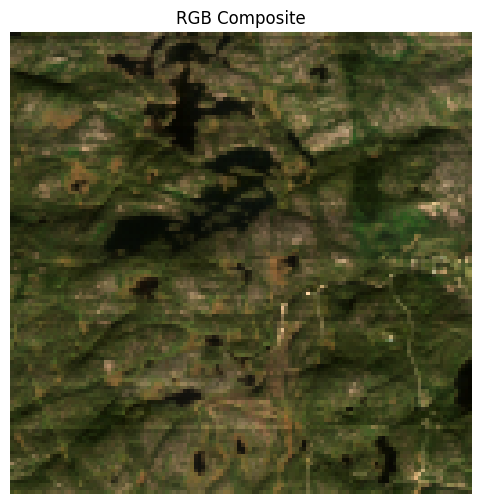

In [288]:
rgb_image = create_rgb_composite(image, red=3, green=2, blue=1)
plt.figure(figsize=(6,6))
plt.imshow(rgb_image)
plt.title('RGB Composite')
plt.axis('off')
plt.show()


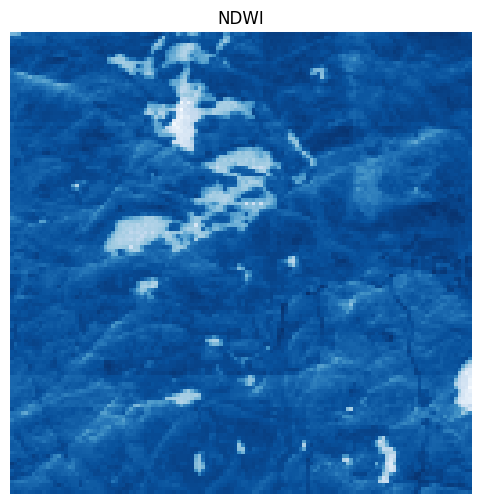

In [289]:
# Example: Sentinel-2 bands (Green: B3, NIR: B8)
ndwi = calculate_ndwi(image[:,:,2], image[:,:,7])
plt.figure(figsize=(6,6))
plt.imshow(ndwi, cmap='Blues')
plt.title('NDWI')
plt.axis('off')
plt.show()


In [290]:
image  = append_new_channel(image)
image.shape

(128, 128, 13)

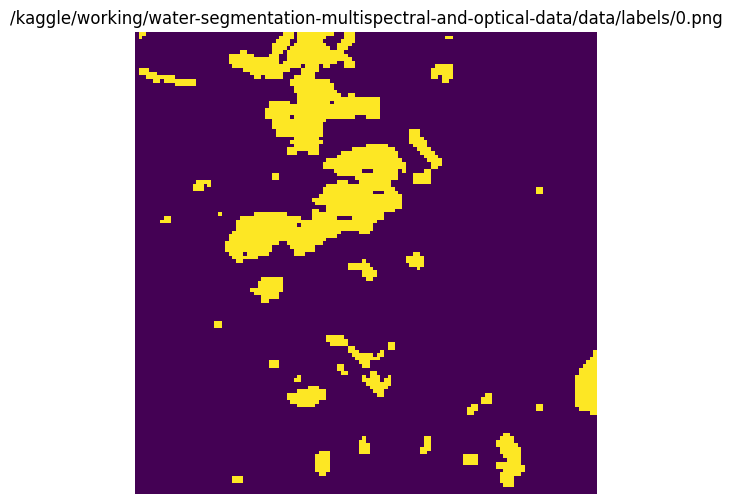

In [291]:

plt.figure(figsize=(6,6))
plt.title(data[LabelAfterEdit][0])
plt.imshow(load_label(data[LabelAfterEdit][0]))
# plt.title('Label')
plt.axis('off')
plt.show()


In [292]:
DataSet={}

DataSet[IMAGES] = [ ]
DataSet[LABEL] = [ ]

for  i in range(len(data[IMAGES])):
    multispectral_bands, _ = load_multispectral_image(data[IMAGES][i])
    multispectral_normalized = normalize(multispectral_bands)
    image  = append_new_channel(multispectral_normalized)
    label = load_label(data[LabelAfterEdit][i])
    DataSet[IMAGES].append(image)
    DataSet[LABEL].append(label)

        
#     multispectral_bands, profile = load_multispectral_image(os.path.join(f'{IMAGES_PATH}/{filenames}'))
#     multispectral_normalized = normalize(multispectral_bands)

In [293]:
def visualize_label(label_array):
    plt.figure(figsize=(6,6))
    plt.imshow(label_array, cmap='jet')  # 'jet' colormap is useful for visualization, adjust as needed
    plt.colorbar()
    plt.axis('off')
    plt.show()

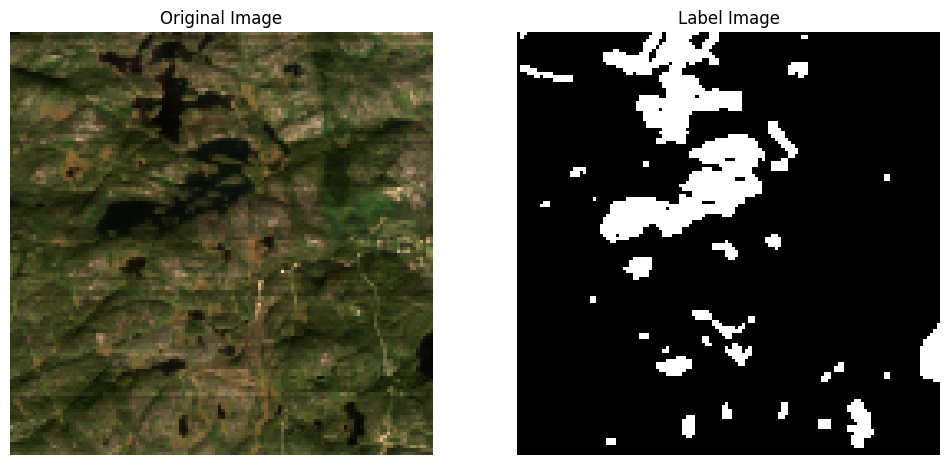

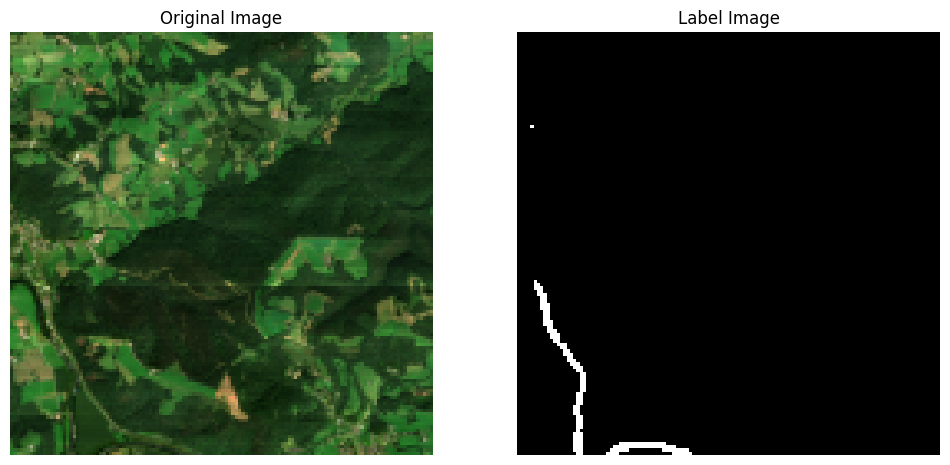

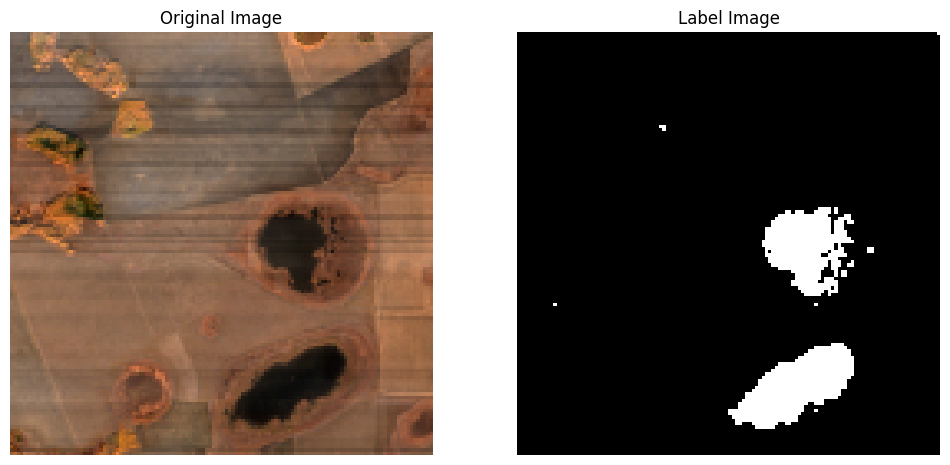

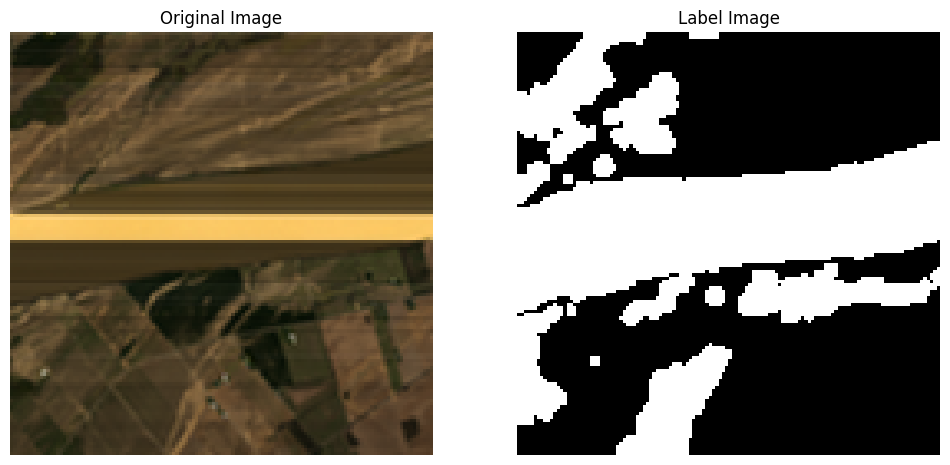

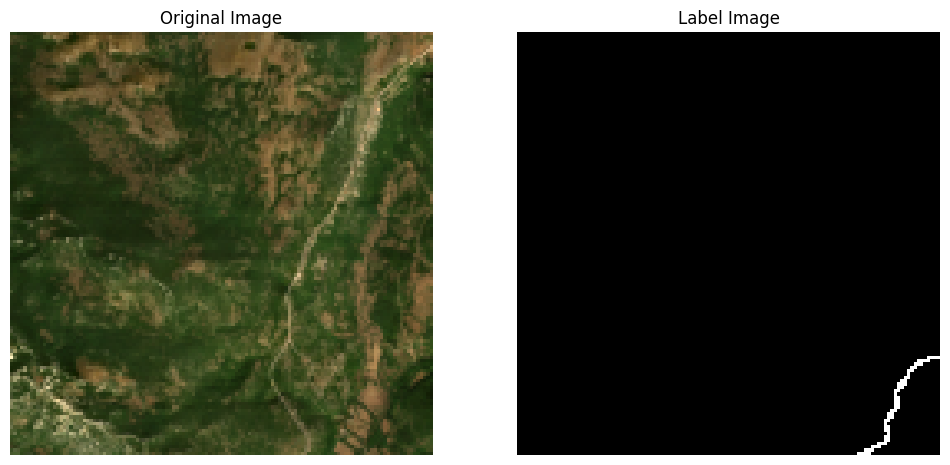

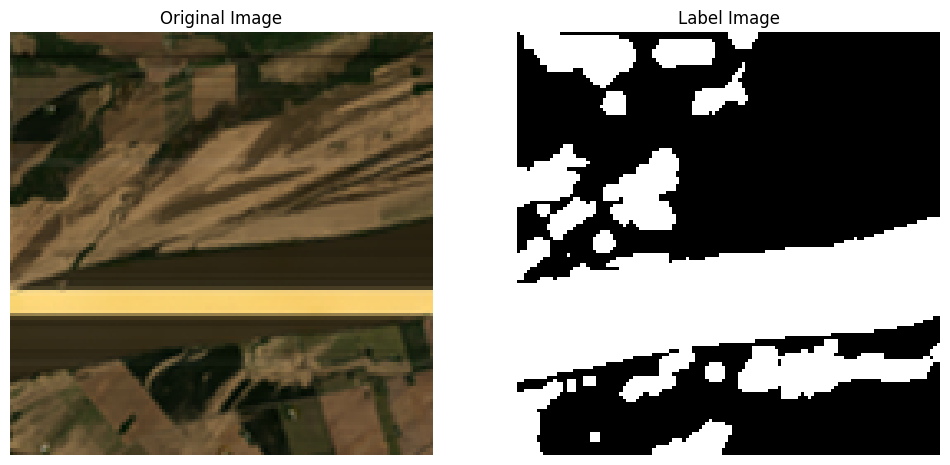

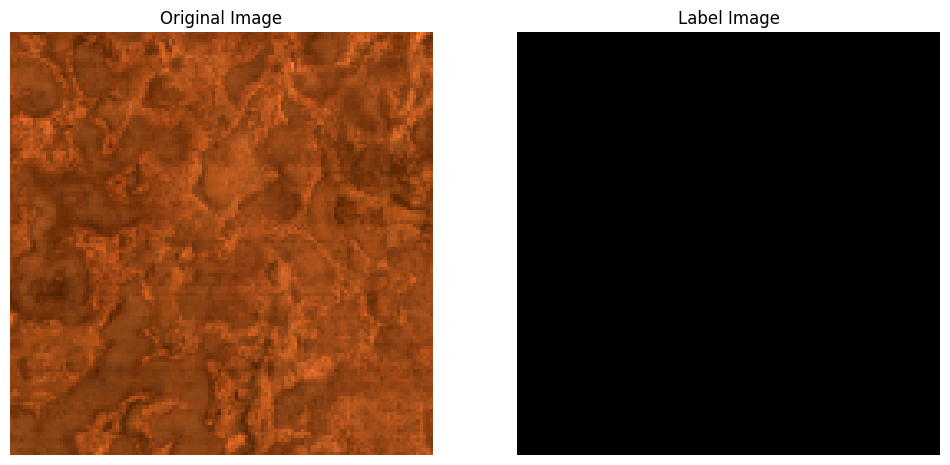

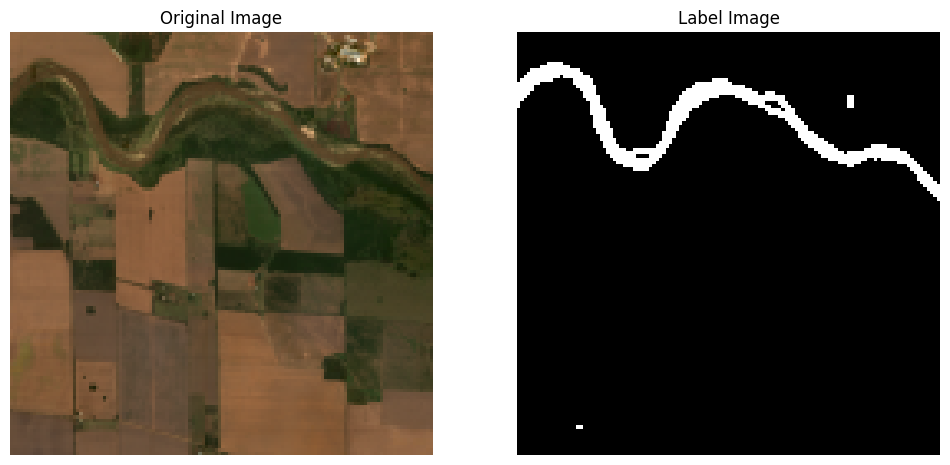

In [294]:
def plot_image_and_label(image, label):
    # Convert BGR to RGB for proper display in matplotlib
    rgb_image = create_rgb_composite(image, red=3, green=2, blue=1)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axes[0].imshow(rgb_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the label image
    axes[1].imshow(label, cmap='gray')  # 'jet' colormap for better visualization
    axes[1].set_title('Label Image')
    axes[1].axis('off')

    plt.show()

for i in range(8):
    plot_image_and_label(DataSet[IMAGES][i], DataSet[LABEL][i])


In [295]:
DataSet[IMAGES][0].shape

(128, 128, 13)

In [296]:
import numpy as np
from sklearn.model_selection import train_test_split

SIZE = 32

def create_patches(data, labels, patch_size=128, overlap=0):
    patches = []
    label_patches = []
    step = patch_size - overlap
    
    # Iterate over the first two dimensions (height and width)
    for i in range(0, data.shape[0] - patch_size + 1, step):
        for j in range(0, data.shape[1] - patch_size + 1, step):
            # Extracting the patch for data
            patch = data[i:i + patch_size, j:j + patch_size, :]
            # Extracting the corresponding patch for labels
            label_patch = labels[i:i + patch_size, j:j + patch_size]
            # Append patches to the respective lists
            patches.append(patch)
            label_patches.append(label_patch)
    
    return np.array(patches), np.array(label_patches)

def process_images(images, labels, patch_size=128, overlap=0):
    all_patches = []
    all_label_patches = []
    
    for img, lbl in zip(images, labels):
        patches, label_patches = create_patches(img, lbl, patch_size, overlap)
        all_patches.append(patches)
        all_label_patches.append(label_patches)
    
    # Concatenate all patches from all images
    all_patches = np.concatenate(all_patches, axis=0)
    all_label_patches = np.concatenate(all_label_patches, axis=0)
    
    return all_patches, all_label_patches

# Example usage:
patches, label_patches = process_images(DataSet[IMAGES], DataSet[LABEL], patch_size=SIZE, overlap=0)
print(f"Total patches: {patches.shape[0]}")

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(patches, label_patches, test_size=0.2, random_state=42)

# Print the shape of training and validation sets
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


Total patches: 4896
Training samples: 3916, Validation samples: 980


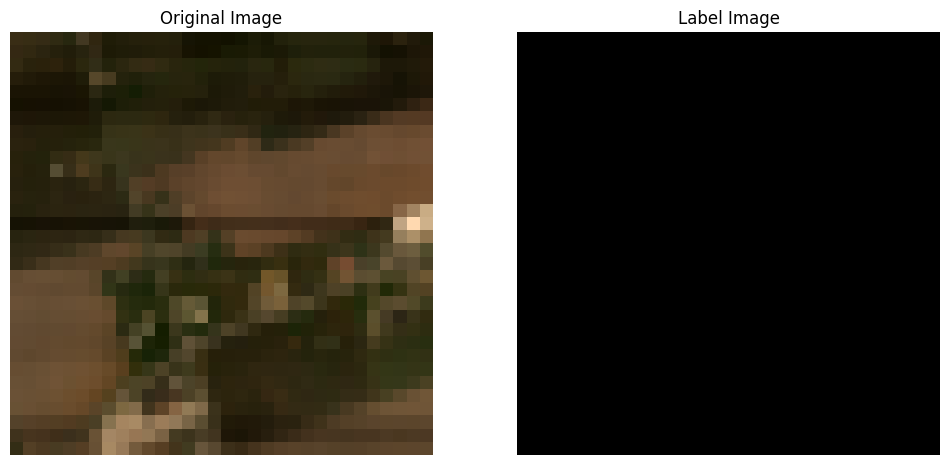

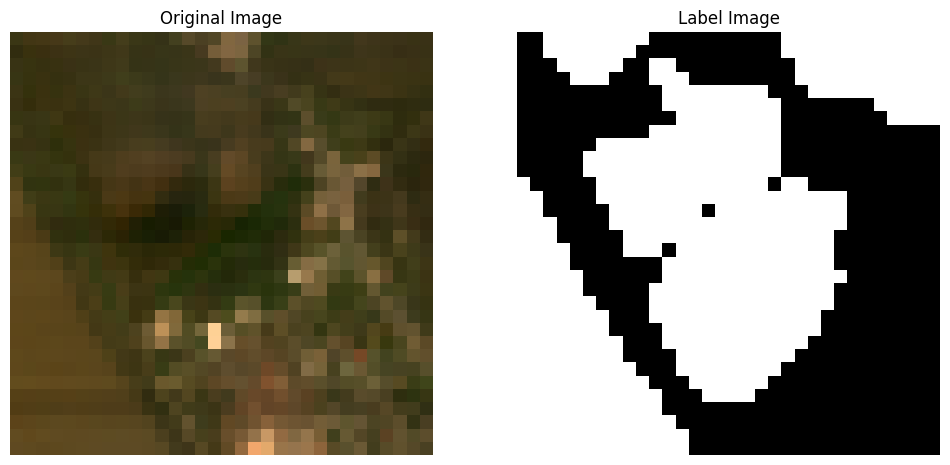

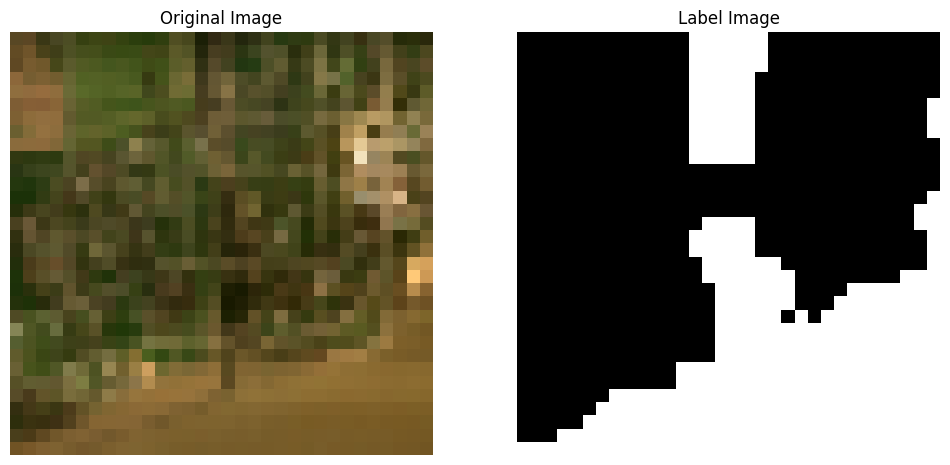

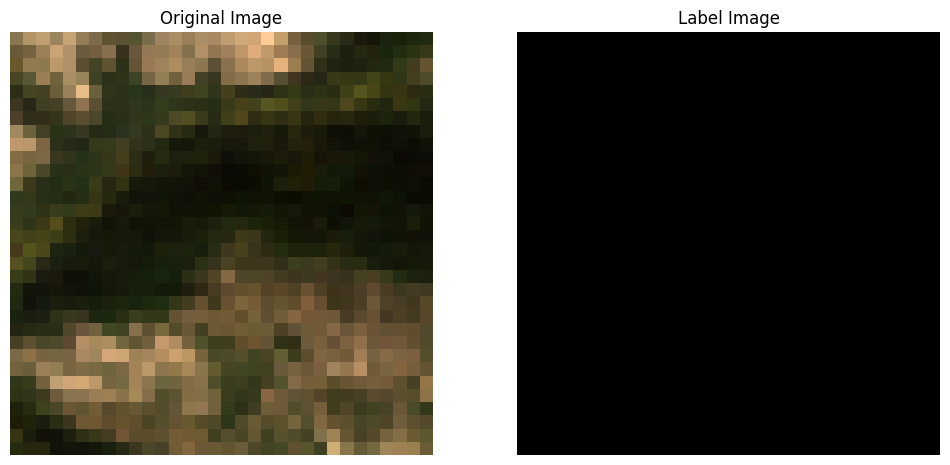

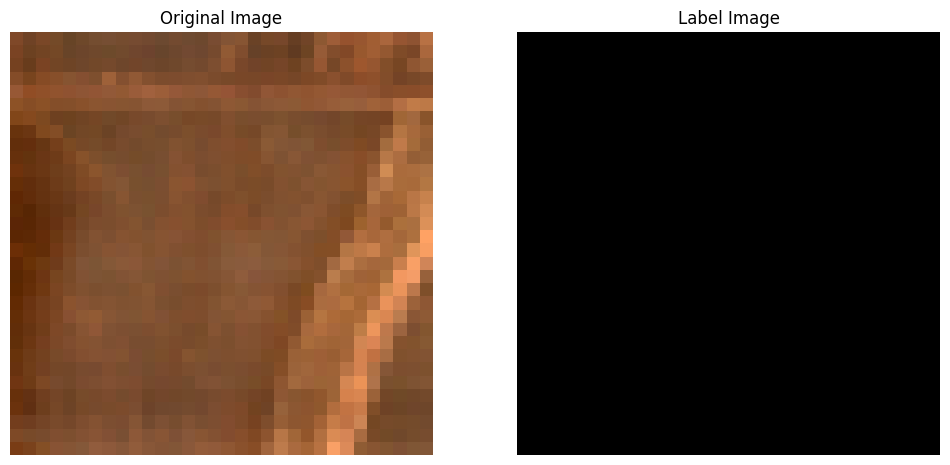

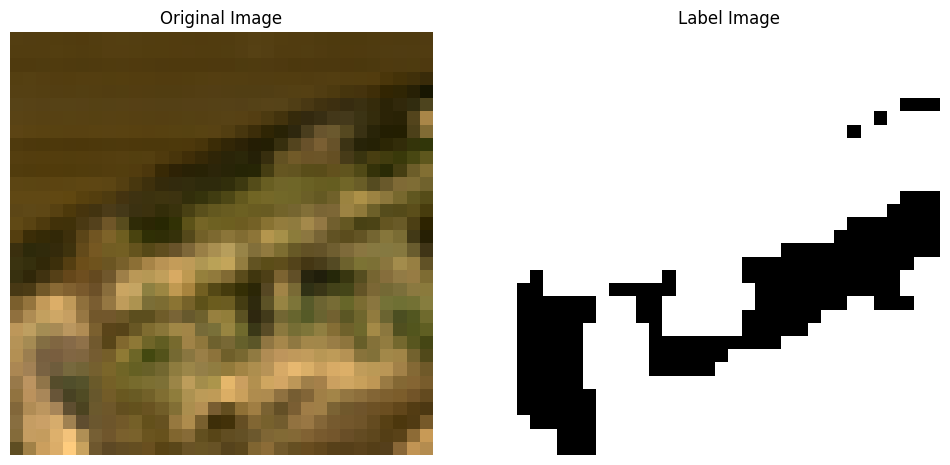

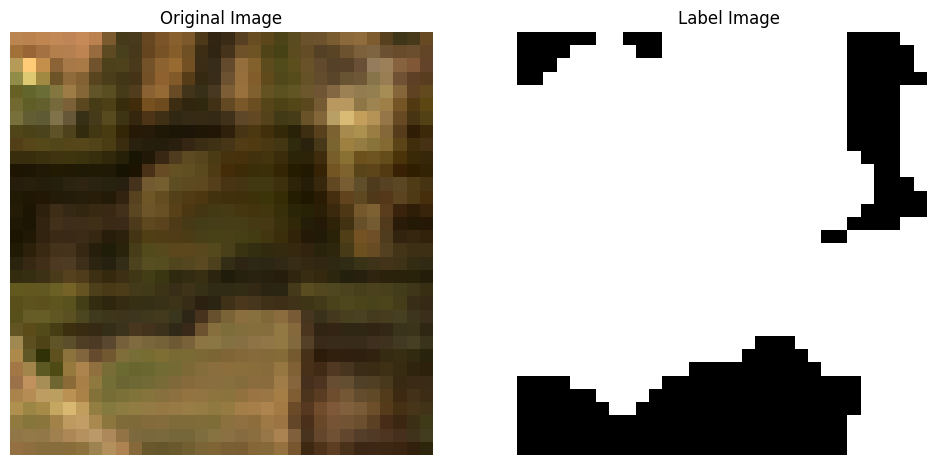

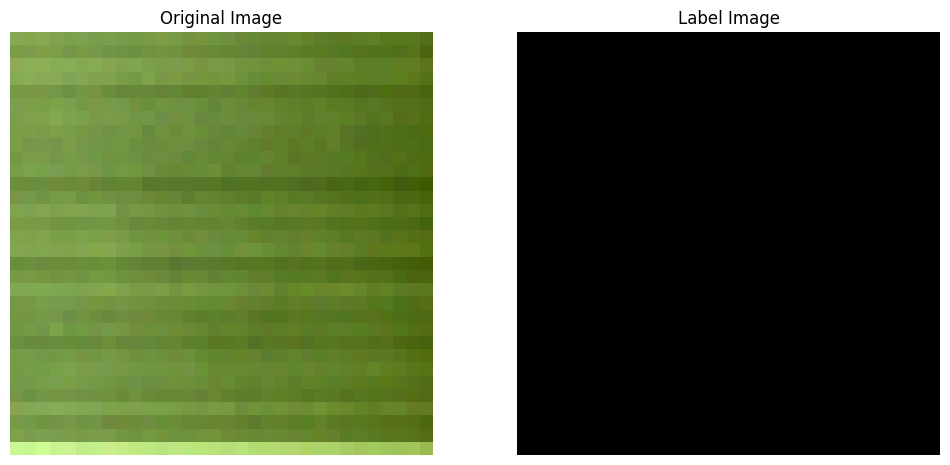

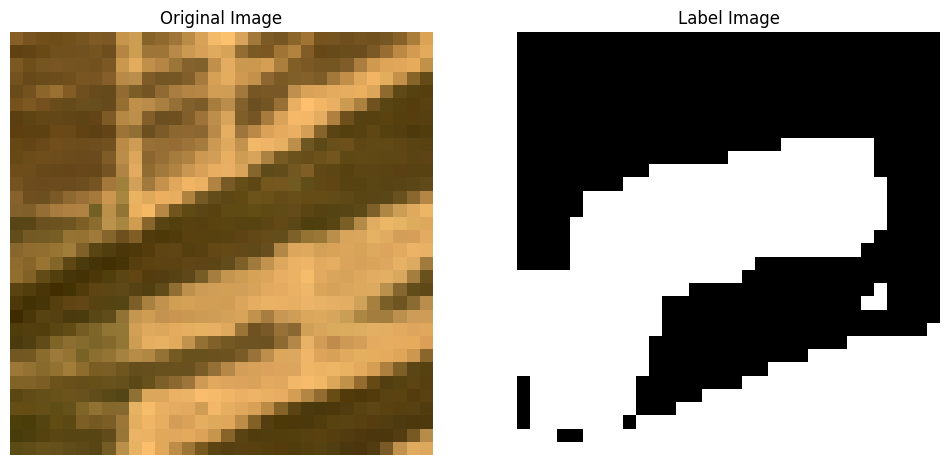

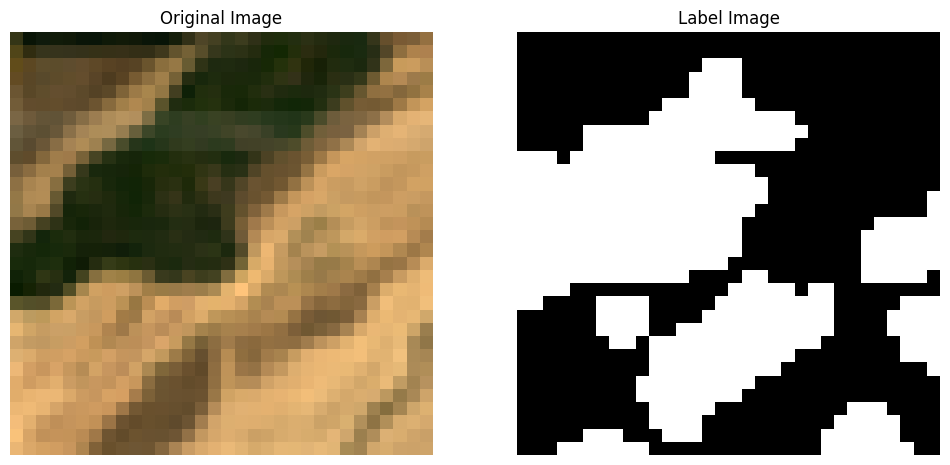

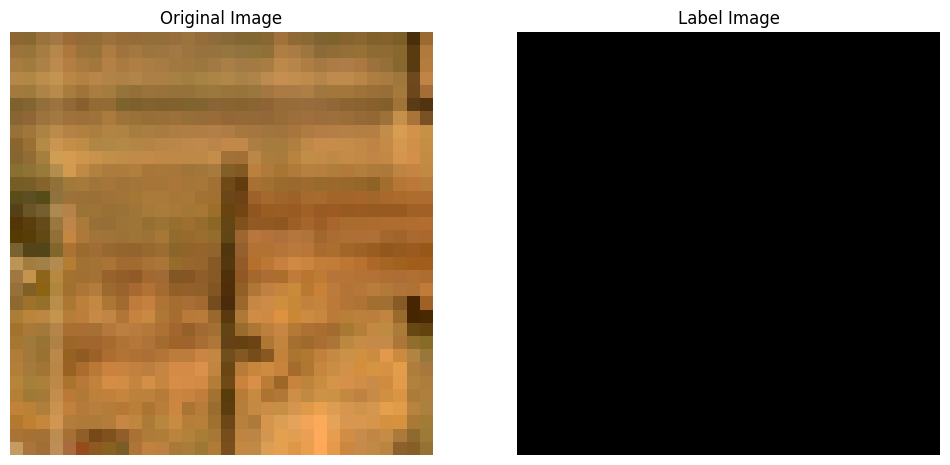

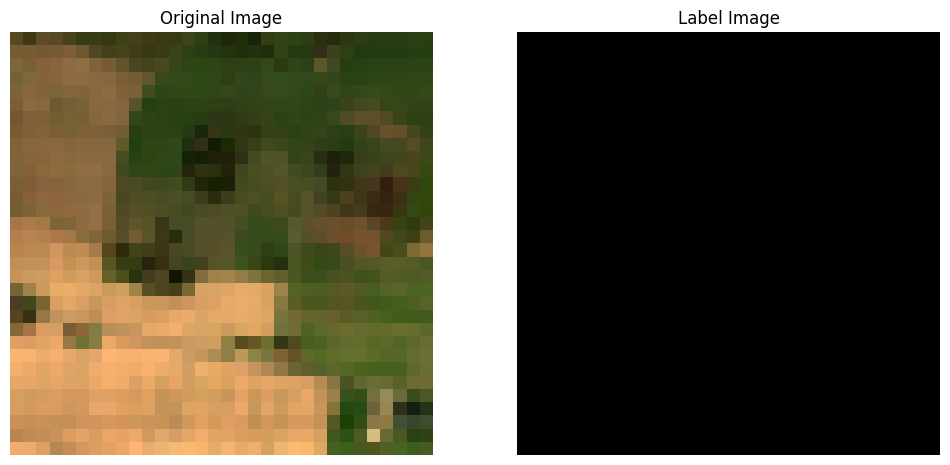

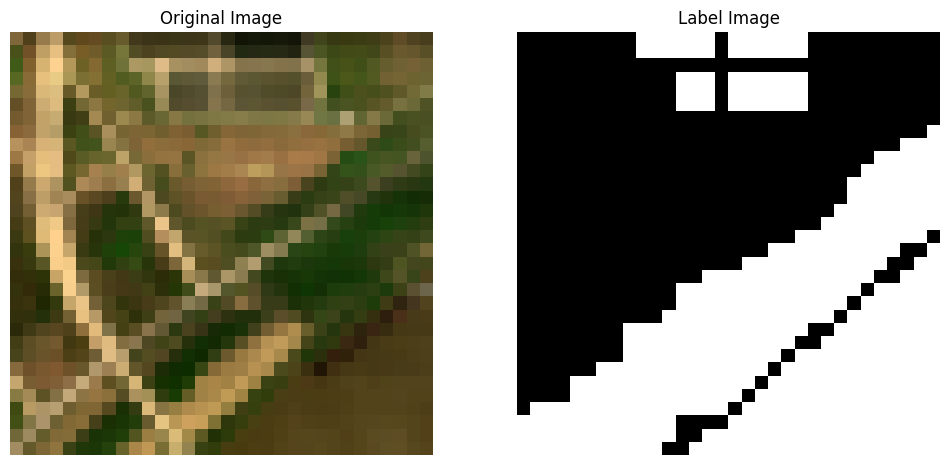

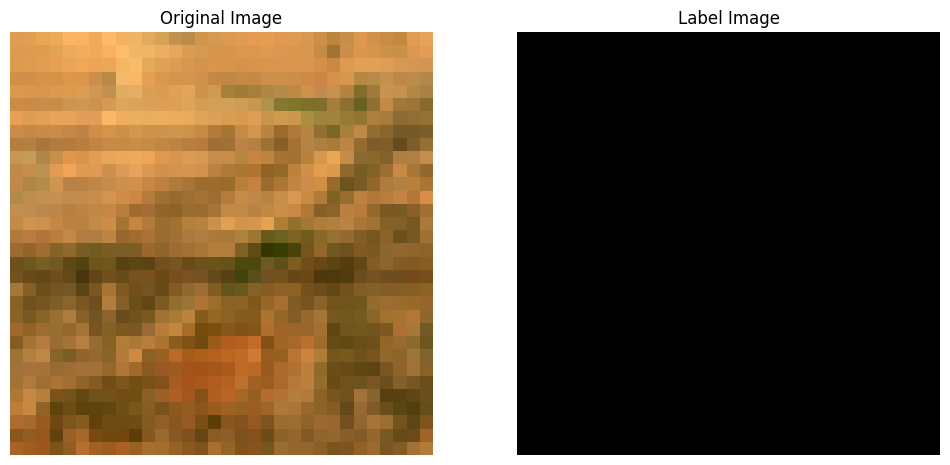

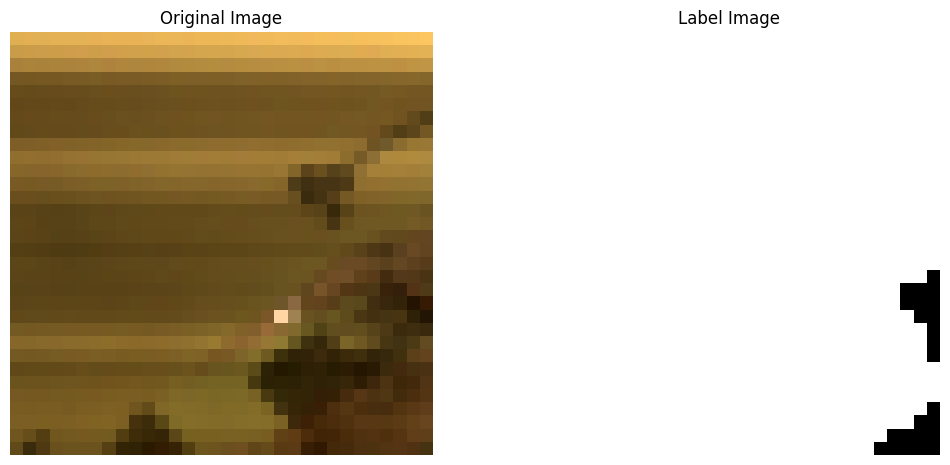

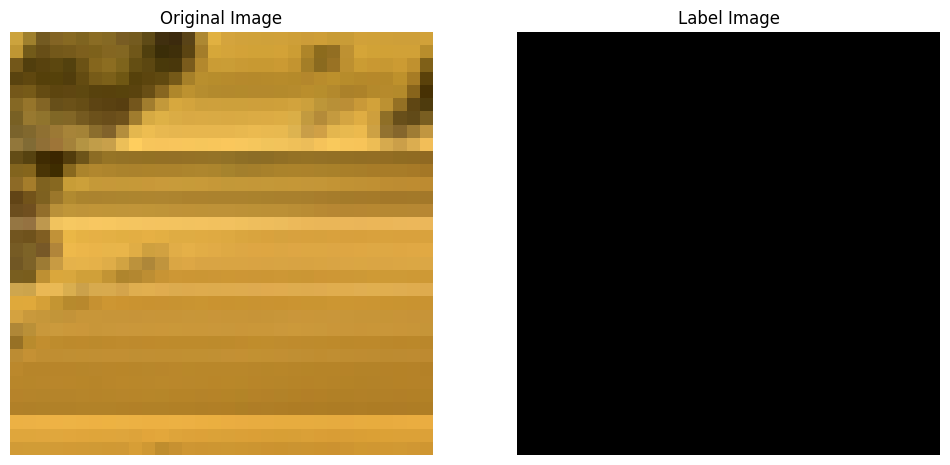

In [297]:
for i in range(int(128/32 * 128/32)):
    plot_image_and_label(X_train[i], y_train[i])

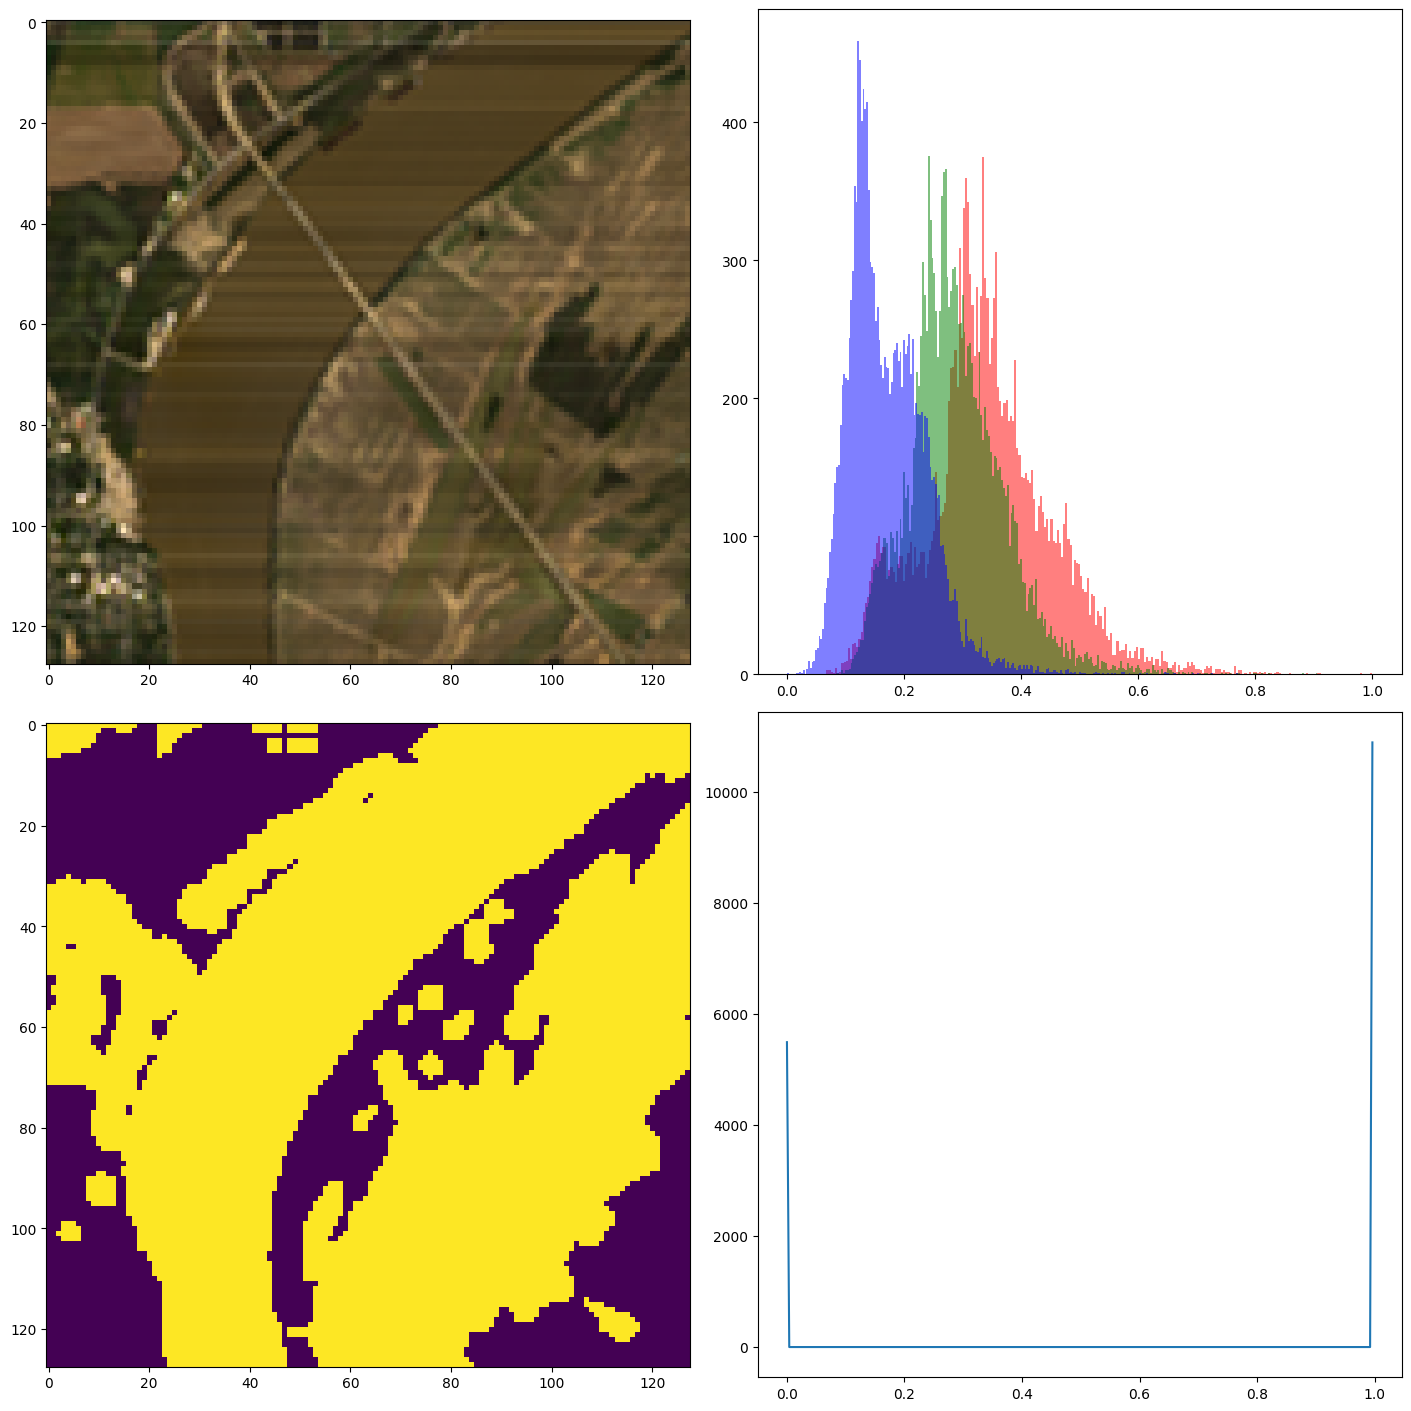

In [298]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14), constrained_layout=True)
example_image, example_mask = create_rgb_composite(DataSet[IMAGES][50], red=3, green=2, blue=1) , DataSet[LABEL][50]
example_image = np.array(example_image)

axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

axs[1][0].imshow(example_mask)
histogram, bin_edges = np.histogram(example_mask, bins=256)
axs[1][1].plot(bin_edges[0:-1], histogram)

In [299]:
X_train[i].shape

(32, 32, 13)

In [300]:
from tensorflow.keras.applications import DenseNet121

Pretrainned_net = DenseNet121(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


In [301]:
for layer in Pretrainned_net.layers:
    print(layer.name)

input_layer_31
zero_padding2d_58
conv1_conv
conv1_bn
conv1_relu
zero_padding2d_59
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_c

In [302]:

# def unet_model(input_size=(SIZE, SIZE, 13), num_classes=2):
#     # EfficientNetB0 as Encoder
    
#     # Encoder Layers from EfficientNet
#     c1 = efficientnet.get_layer("block1a_activation").output  # Size: (64, 64, 32)
#     c2 = efficientnet.get_layer("block2b_add").output  # Size: (32, 32, 24)
#     c3 = efficientnet.get_layer("block3b_add").output  # Size: (16, 16, 40)
#     c4 = efficientnet.get_layer("block4c_add").output  # Size: (8, 8, 80)
    
#     # Bottleneck
#     c5 = efficientnet.get_layer("block6d_add").output  # Size: (4, 4, 192)
    
#     # Decoder
#     u6 = layers.Conv2DTranspose(80, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(80, (3, 3), activation='relu', padding='same')(u6)
#     c6 = layers.Conv2D(80, (3, 3), activation='relu', padding='same')(c6)
    
#     u7 = layers.Conv2DTranspose(40, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(40, (3, 3), activation='relu', padding='same')(u7)
#     c7 = layers.Conv2D(40, (3, 3), activation='relu', padding='same')(c7)
    
#     u8 = layers.Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(24, (3, 3), activation='relu', padding='same')(u8)
#     c8 = layers.Conv2D(24, (3, 3), activation='relu', padding='same')(c8)
    
#     u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1])
#     c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
#     c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    
#     # Upsample one more time to match the original input size
#     u10 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
#     c10 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u10)
#     c10 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c10)
    
#     outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c10)
    
#     model = models.Model(inputs=[efficientnet.input], outputs=[outputs])
#     return model

# # Instantiate the model
# model = unet_model(input_size=(SIZE, SIZE, 13), num_classes=2)
# model.summary()


In [303]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
import tensorflow as tf

def unet_model(input_size=(SIZE, SIZE, 13), num_classes=2):
    # Modify DenseNet121 input layer to accept 13 channels
    base_model = DenseNet121(weights=None, include_top=False, input_shape=input_size)
    
    # Encoder Layers from DenseNet121
    c1 = base_model.get_layer("conv1_relu").output  # Size: (64, 64, 64)
    c2 = base_model.get_layer("pool2_relu").output  # Size: (32, 32, 128)
    c3 = base_model.get_layer("pool3_relu").output  # Size: (16, 16, 256)
    c4 = base_model.get_layer("pool4_relu").output  # Size: (8, 8, 512)
    
    # Bottleneck
    c5 = base_model.get_layer("relu").output  # Size: (4, 4, 1024)

   # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    # Upsample one more time to match the original input size
    u10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u10)
    c10 = layers.BatchNormalization()(c10)
    c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c10)
    c10 = layers.BatchNormalization()(c10)

    # Output layer for segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c10)

    model = models.Model(inputs=[base_model.input], outputs=[outputs])
    return model

# Define the input shape with 13 channels and the number of classes for the output layer
model = unet_model(input_size=(SIZE, SIZE, 13), num_classes=2)

# Print model summary


In [304]:
print(model)

<Functional name=functional_19, built=True>


In [305]:
model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_60   │ (None, 38, 38,    │          0 │ input_layer_32[0… │
│ (ZeroPadding2D)     │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │     40,768 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_61   │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 8, 8, 64)  │          0 │ zero_padding2d_6… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 64)  │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_0_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 128) │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 128) │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 128) │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 32)  │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 8, 8, 96)  │          0 │ pool1[0][0],      │
│ (Concatenate)       │                   │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 8, 8, 96)  │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 8, 8, 96)  │          0 │ conv2_block2_0_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 8, 8, 128) │     12,288 │ conv2_block2_0_r

 Total params: 22,452,546 (85.65 MB)

 Trainable params: 22,364,802 (85.31 MB)

 Non-trainable params: 87,744 (342.75 KB)

In [306]:
from sklearn.utils.class_weight import compute_class_weight

# Flatten y_train to create a 1D array of labels
y_train_flattened = y_train.flatten()

# Get unique class labels
unique_classes = np.unique(y_train_flattened)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_flattened
)

# Create a dictionary for class weights
class_weights_dict = dict(zip(unique_classes, class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.6749024164632415, 1: 1.9293684733197587}


In [307]:
# Create sample weights based on class weights
def create_sample_weights(y, class_weights_dict):
    flattened_y = y.flatten()
    sample_weights = np.array([class_weights_dict[label] for label in flattened_y])
    return sample_weights.reshape(y.shape)

# Create sample weights for training data
sample_weights = create_sample_weights(y_train, class_weights_dict)


In [308]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [309]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [310]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (3916, 32, 32, 13)
y_train shape: (3916, 32, 32, 2)
X_val shape: (980, 32, 32, 13)
y_val shape: (980, 32, 32, 2)


In [311]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('unet_water_segmentation.keras',
    monitor='val_loss', 
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    sample_weight=sample_weights,
    callbacks=[early_stopping, checkpoint,lr_reduce]
)


Epoch 1/150
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8084 - loss: 0.4653

I0000 00:00:1725875978.937010     155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_rsqrt_fusion_20', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_20', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_rsqrt_fusion_4', 4 bytes spill stores, 4 bytes spill loads



123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.8086 - loss: 0.4647
Epoch 1: val_loss improved from inf to 0.31137, saving model to unet_water_segmentation.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 219s 712ms/step - accuracy: 0.8089 - loss: 0.4640 - val_accuracy: 0.8907 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8600 - loss: 0.3278
Epoch 2: val_loss improved from 0.31137 to 0.26507, saving model to unet_water_segmentation.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8600 - loss: 0.3278 - val_accuracy: 0.8862 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8703 - loss: 0.2961
Epoch 3: val_loss did not improve from 0.26507
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8703 - loss: 0.2961 - val_accuracy: 0.4041 - val_loss: 1.3090 - learning_rate: 0.0010
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8819 - los

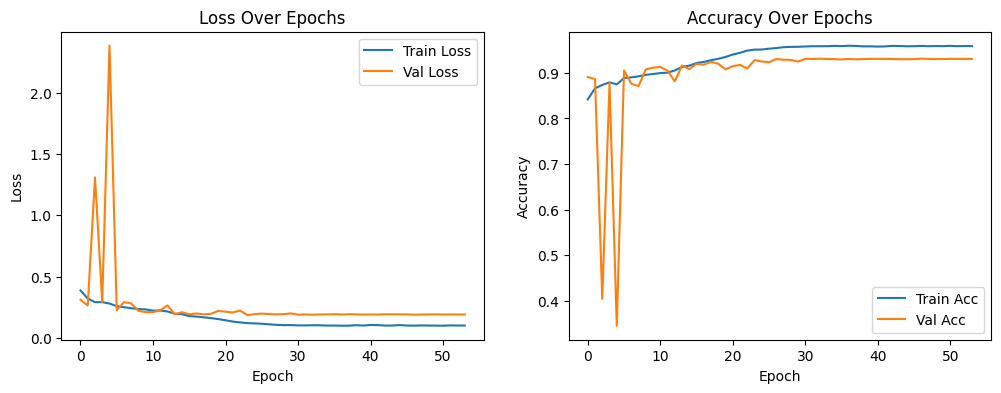

In [312]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [313]:
predictions=model.predict(X_val)
print(predictions.shape)


31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step
(980, 32, 32, 2)


In [314]:
# Save the entire model as a `.keras` zip archive.
model.save('pretrained_model.keras')
# assign location
path='/kaggle/working/tets.weights.h5'
 
# save
model.save_weights(path)

In [315]:
X_val[0].shape

(32, 32, 13)

In [316]:
y_val.shape

(980, 32, 32, 2)

In [317]:
print(y_val[0].max() ,",", y_val[0].min())

1.0 , 0.0


In [318]:
binary_predictions = (y_val[0] >= 0.5).astype(np.uint8)

(-0.5, 31.5, 31.5, -0.5)

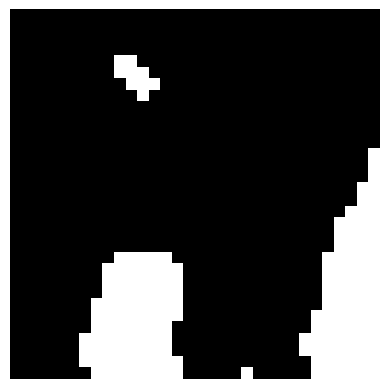

In [319]:
plt.imshow(np.argmax(y_val[10], axis=-1), cmap='gray')  # Use grayscale for labels
# plt.set_title('Ground Truth')
plt.axis('off')

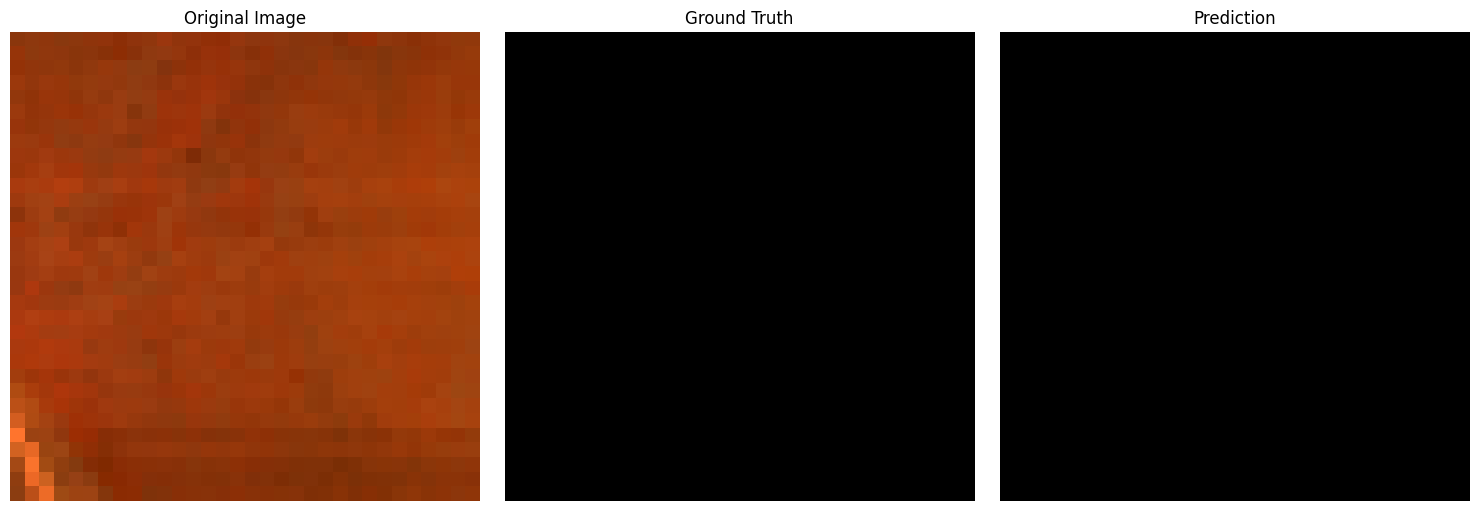

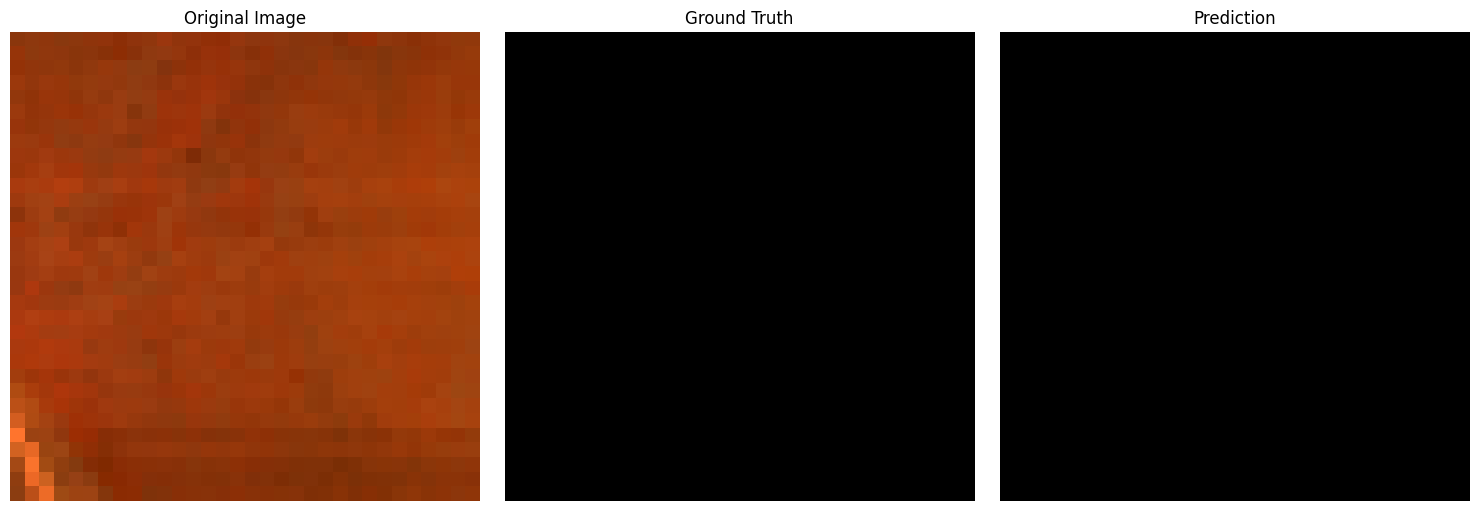

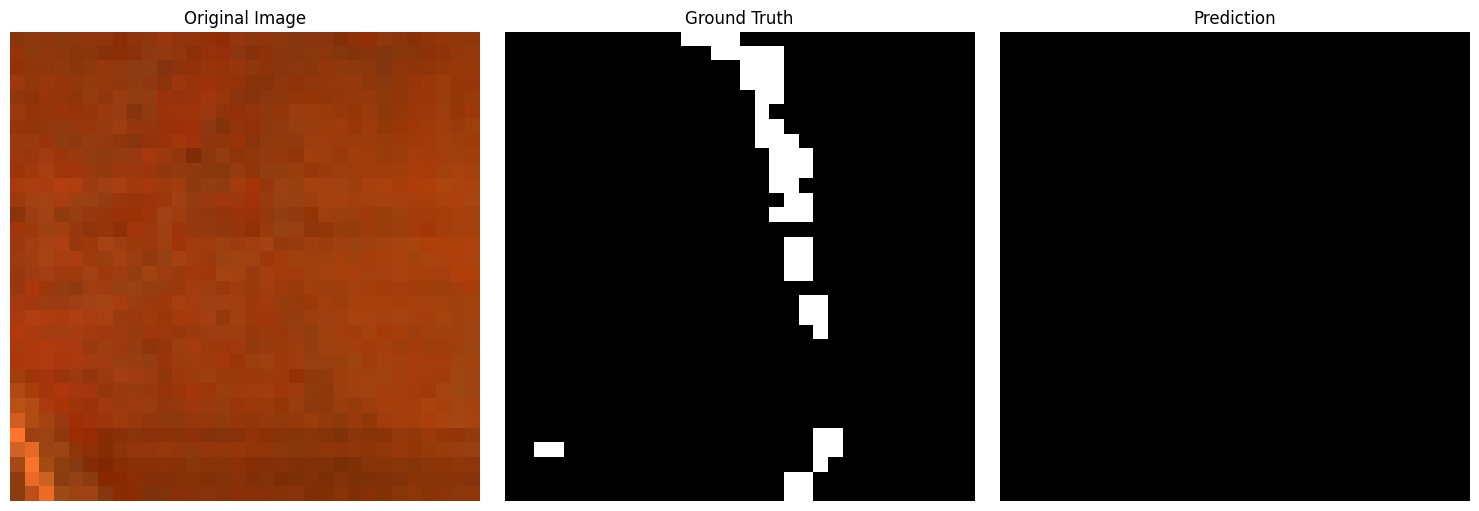

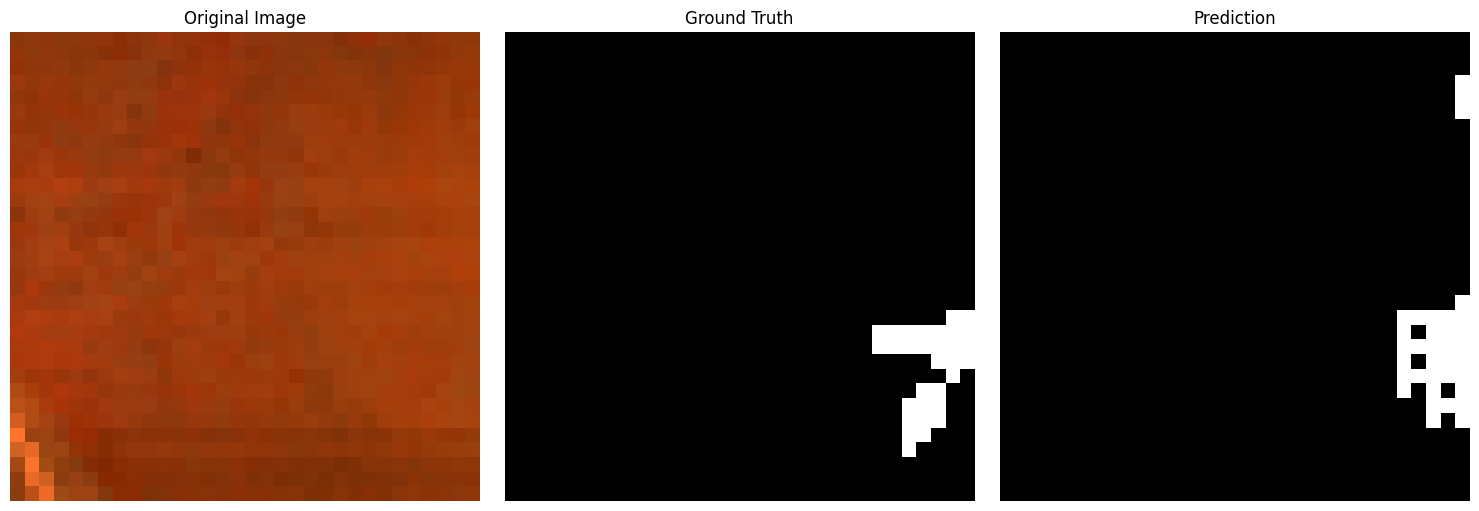

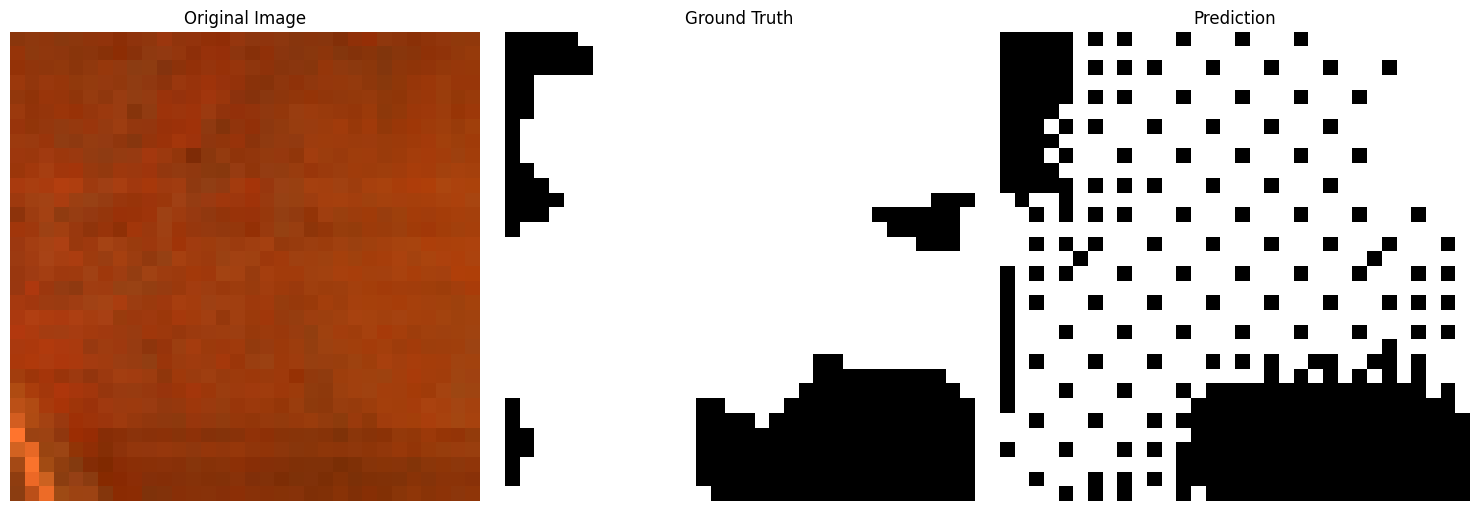

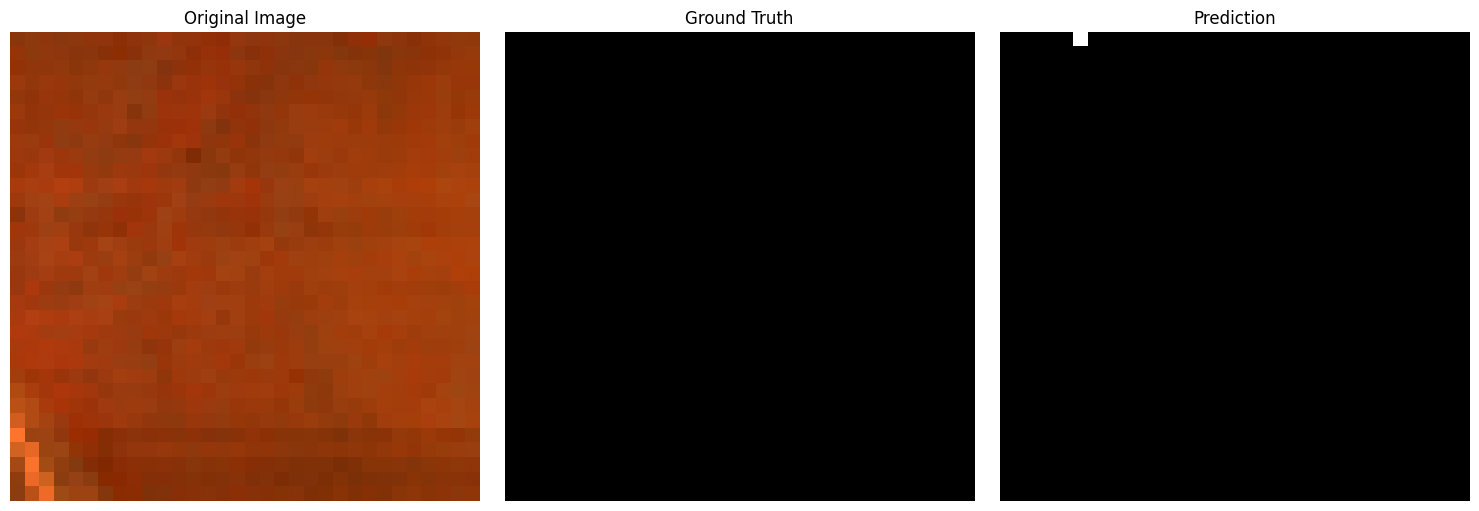

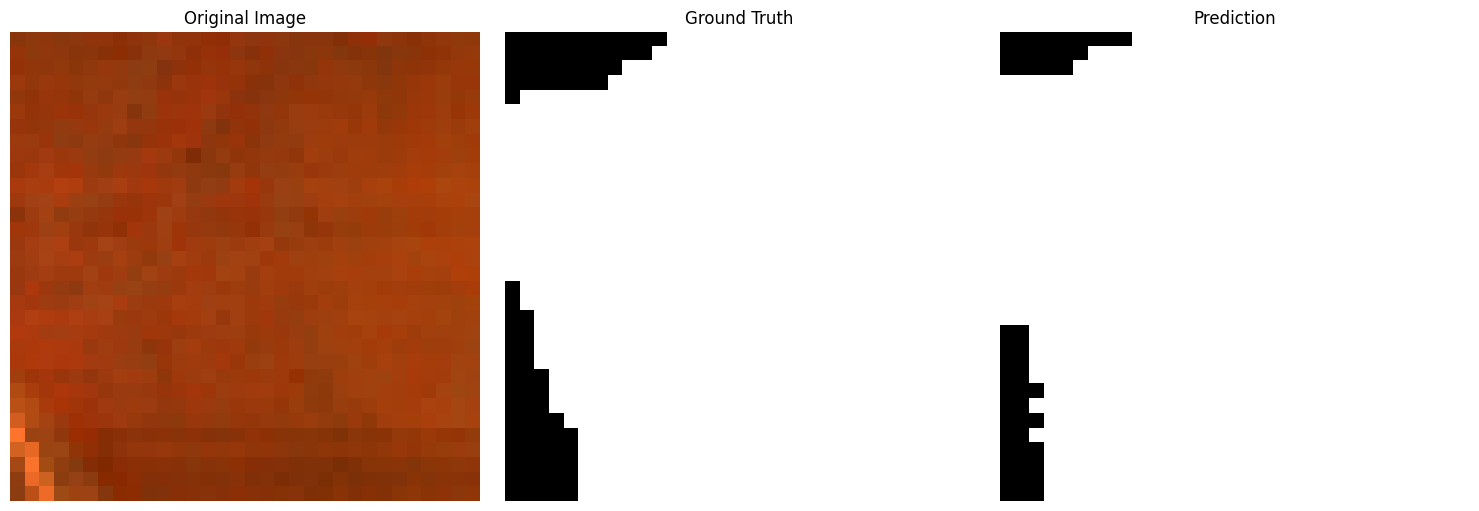

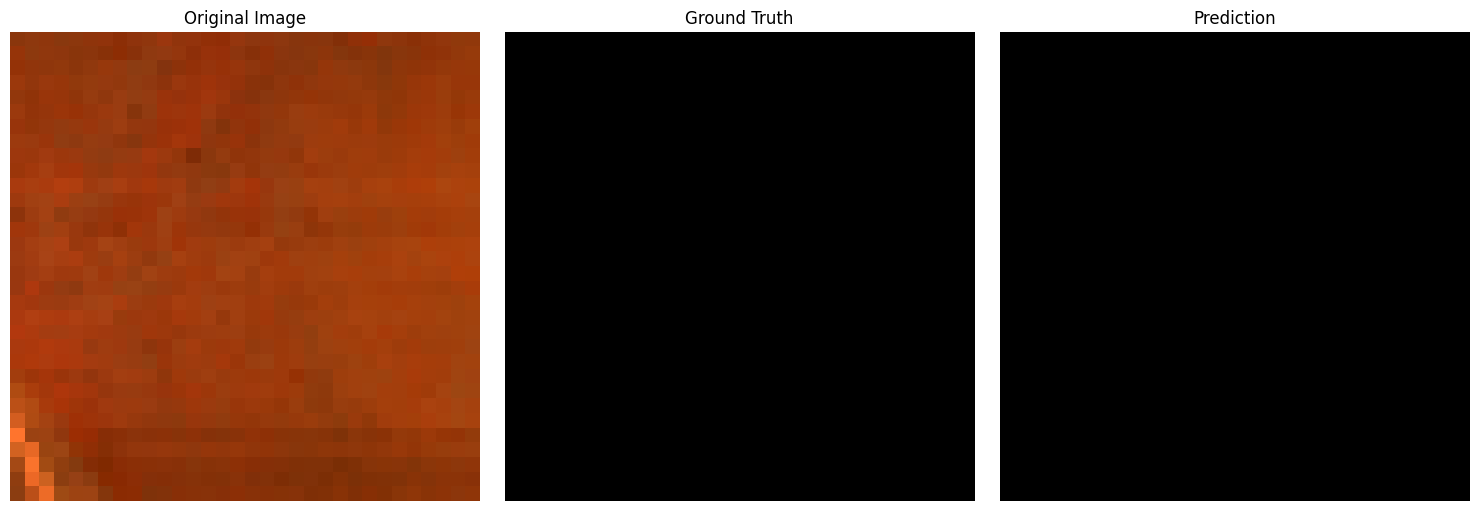

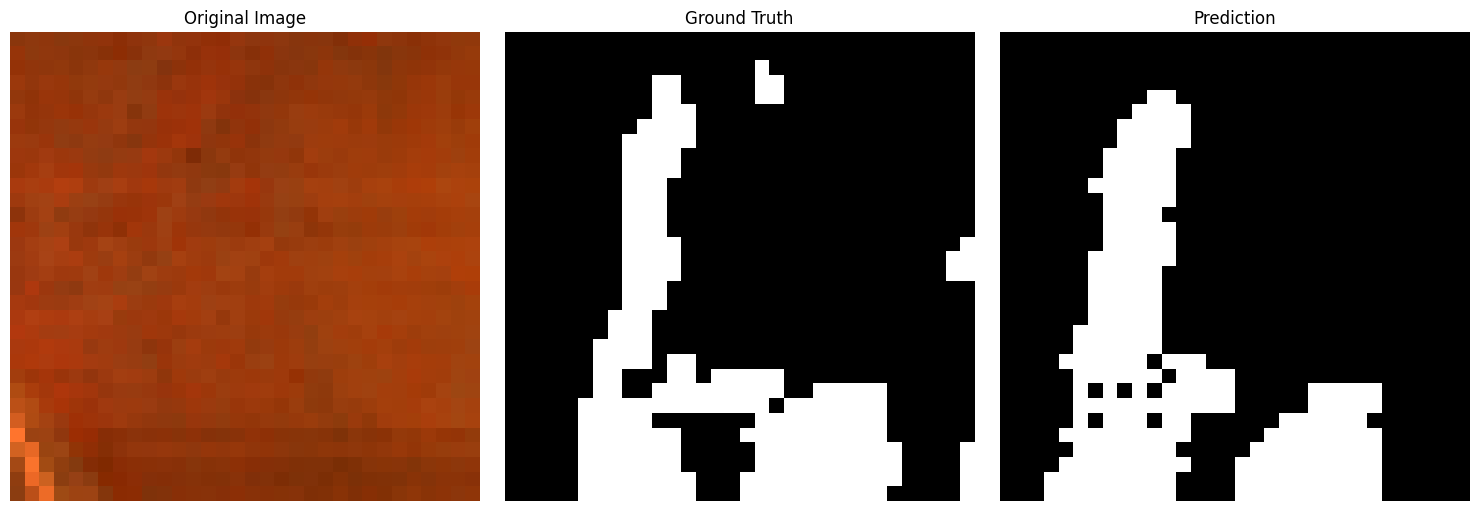

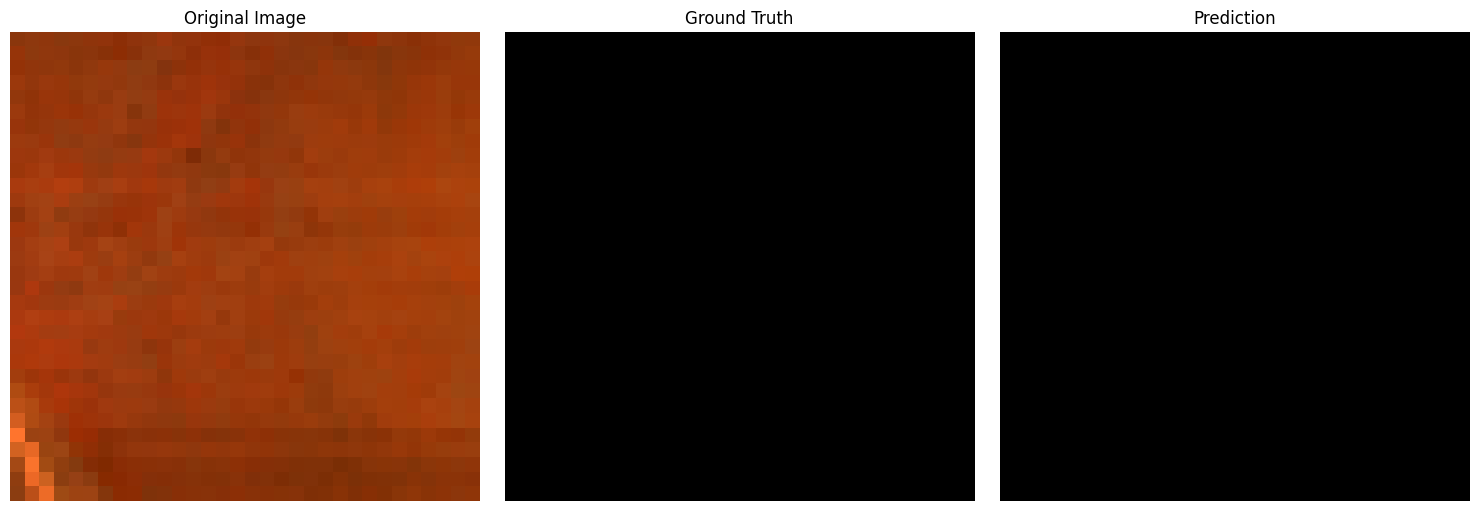

In [320]:
# Apply threshold of 0.5 to convert probabilities into binary values (0 or 1)
binary_predictions = (predictions >= 0.5).astype(np.uint8)

def plot_image_label_prediction(image, label, prediction, index=0):
    """
    Plots the image, label, and prediction side by side.
    
    Args:
    - image (numpy array): The original input image.
    - label (numpy array): The ground truth segmentation label.
    - prediction (numpy array): The predicted segmentation.
    - index (int): The index of the image to plot (if working with batches).
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Hide the axes

    # Plot the ground truth label
    ax[1].imshow(np.argmax(label[index], axis=-1), cmap='gray')  # Use grayscale for labels
    ax[1].set_title('Ground Truth')
    ax[1].axis('off')

    # Plot the prediction
    ax[2].imshow(np.argmax(prediction[index], axis=-1), cmap='gray')  # Assuming binary segmentation
    ax[2].set_title('Prediction')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    
Image = create_rgb_composite(X_val[0], red=3, green=2, blue=1)



for index in range(0,1000,100):
    # Display the first test sample and its prediction
    plot_image_label_prediction(Image, y_val, binary_predictions,index)

In [321]:
from tensorflow.keras.models import load_model
savedModel=load_model('/kaggle/working/pretrained_model.keras')
# savedModel.summary()

In [322]:
# Evaluate the model
eval_results = model.evaluate(X_val, y_val)

# Assuming you have one loss and multiple metrics, you can unpack as follows:
loss = eval_results[0]
metrics = eval_results[1:]

print("Loss: {:5.2f}".format(loss))
for metric_name, metric_value in zip(model.metrics_names[1:], metrics):
    print(f"{metric_name}: {metric_value:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9284 - loss: 0.1873
Loss:  0.19
compile_metrics: 0.9278


In [323]:
# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_val, axis=-1)

print(y_pred_classes.shape , y_true_classes.shape )

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(980, 32, 32) (980, 32, 32)


In [324]:
# Flatten the arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Classification report


In [325]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_flat, y_pred_flat))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95    740444
           1       0.83      0.92      0.87    263076

    accuracy                           0.93   1003520
   macro avg       0.90      0.92      0.91   1003520
weighted avg       0.93      0.93      0.93   1003520



In [326]:
# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)

[[690352  50092]
 [ 22334 240742]]


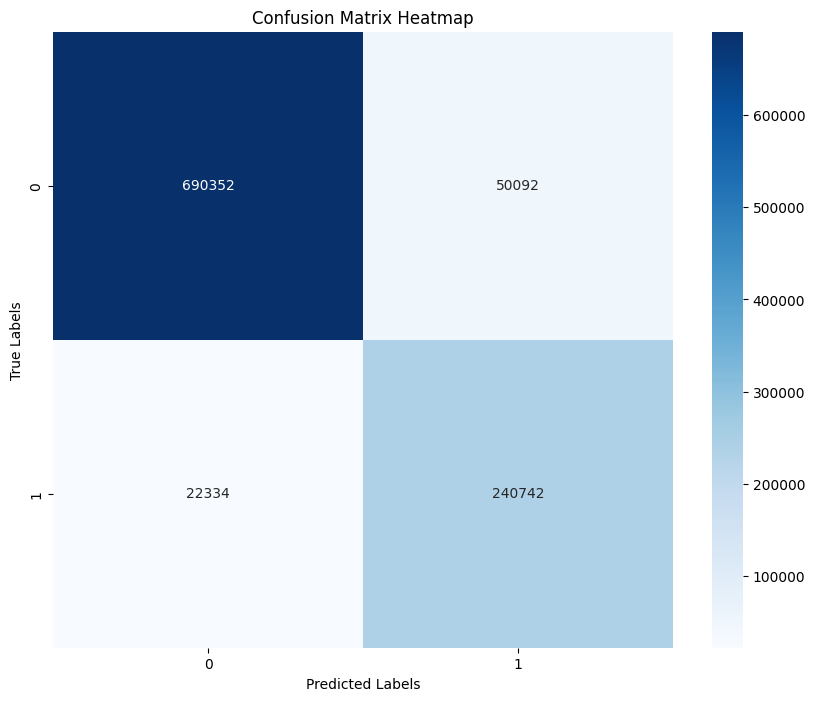

In [327]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()